# U-Net: Convolutional Networks for Biomedical Image Segmentation
[APA Reference] Ronneberger, O., Fischer, P., & Brox, T. (2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

In [1]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [2]:
def conv2D_ReLU(x, filters, kernel_size):
    x = tf.keras.layers.Conv2D(filters, kernel_size)(x)
    x = tf.keras.layers.ReLU()(x)

    return x


def contracting(x, filters, kernel_size = 3, pooling = True):
    if pooling:
        x = tf.keras.layers.MaxPool2D((2, 2), strides = 2)(x)

    x = conv2D_ReLU(x, filters, kernel_size)
    x = conv2D_ReLU(x, filters, kernel_size)

    return x


def expansive(x_1, x_2, filters, kernel_size = 3):
    x_1 = tf.keras.layers.Conv2DTranspose(filters, 2, strides = 2)(x_1)
    x_2 = tf.keras.layers.Cropping2D(
        ((x_2.shape[1] - x_1.shape[1])//2, (x_2.shape[2] - x_1.shape[2])//2))(x_2)
    x_2 = tf.keras.layers.Concatenate(axis = -1)([x_2, x_1]) # x_2 first

    x_2 = conv2D_ReLU(x_2, filters, kernel_size)
    x_2 = conv2D_ReLU(x_2, filters, kernel_size)

    return x_2

In [3]:
IMAGE_SIZE = [572, 572]

def create_NN(model_name):
    model_input = tf.keras.layers.Input((*IMAGE_SIZE, 1))

    ## Contracting Flow
    segments = [model_input]
    for filters in [64, 128, 256, 512, 1024]:
        x = contracting(segments[-1], filters, pooling = False if filters == 64 else True)
        segments.append(x)

    
    ## Expansive Flow
    for filters in [512, 256, 128, 64]:
        x_1, x_2 = segments.pop(), segments.pop()
        x = expansive(x_1, x_2, filters, kernel_size = 3)
        segments.append(x)


    ## Exit Flow
    model_output = tf.keras.layers.Conv2D(2, 1)(x)

    model = tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name)
    
    return model

In [4]:
tmp = create_NN("tmp")
tmp.summary()

Model: "tmp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 572, 572, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 570, 570, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 570, 570, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 568, 568, 64) 36928       re_lu[0][0]                      
________________________________________________________________________________________________

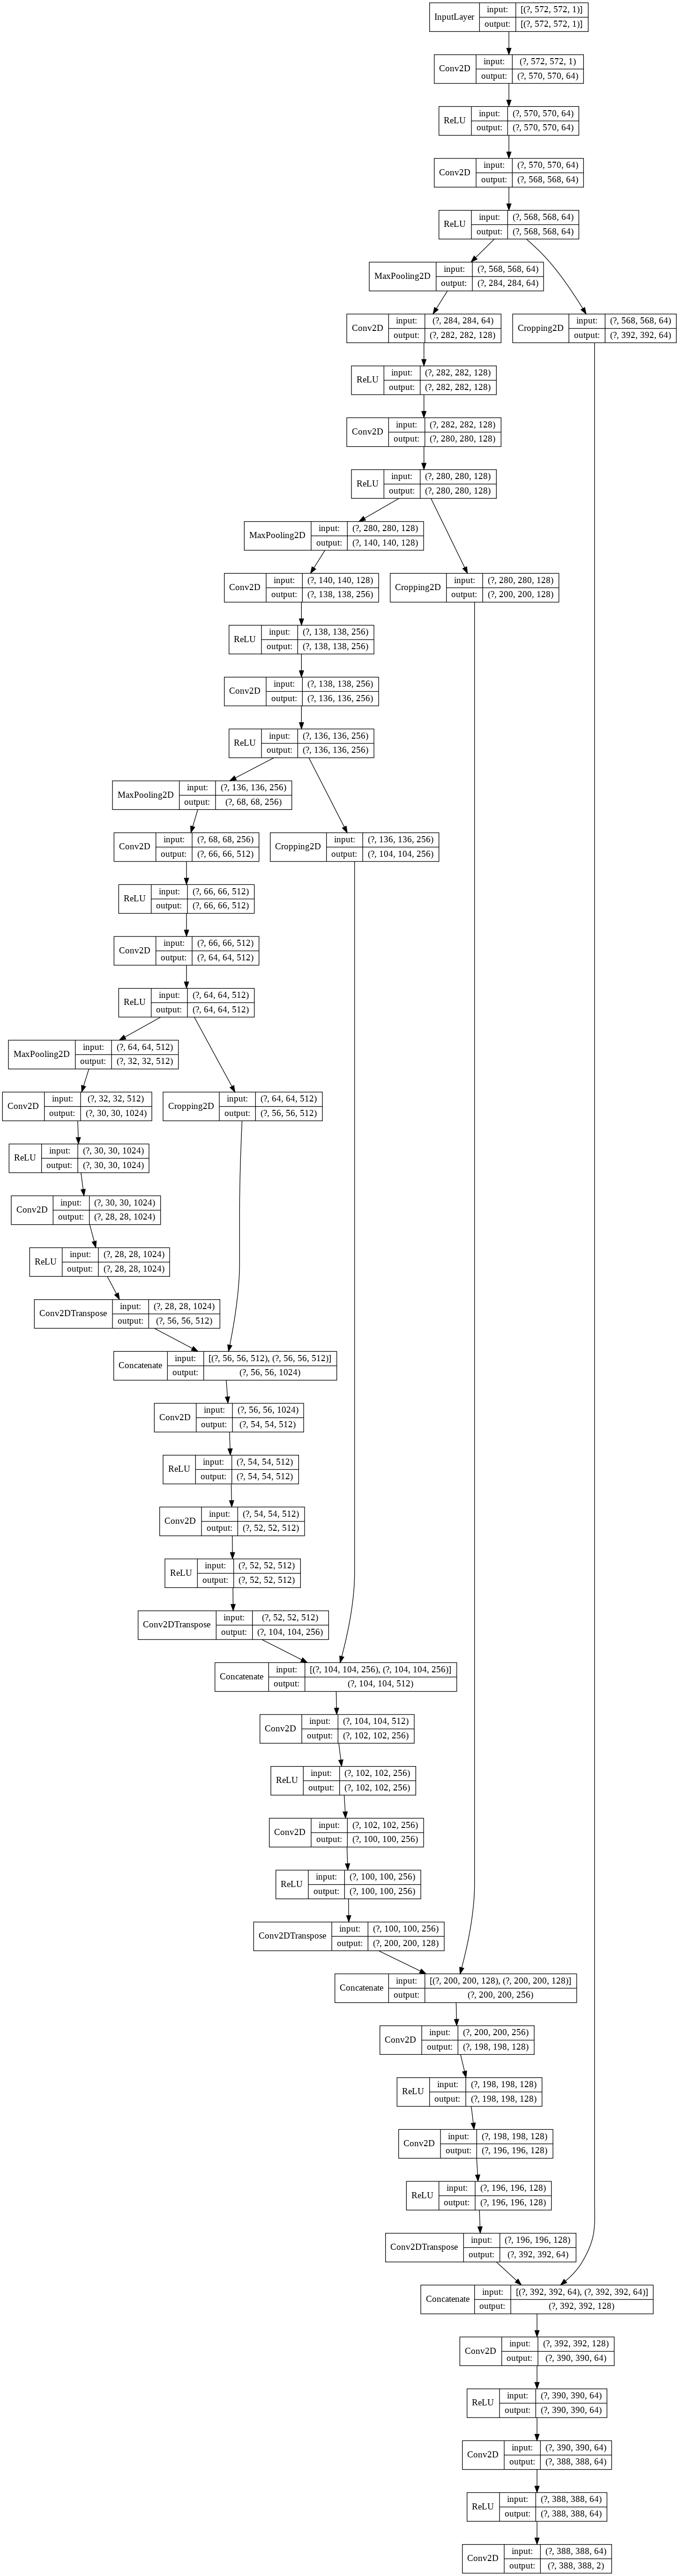

In [5]:
tf.keras.utils.plot_model(tmp, show_shapes = True, show_layer_names = False)